![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Calibración de parámetros de redes neuronales
En este notebook aprenderá a calibrar parámetros de redes neuronales con dos diferentes metodologías usando la librería Keras y sklearn.model_selection.

## Instrucciones Generales

Este notebook esta compuesto por tres secciones. En la primera sección, usted beberá calibrar una red neuronal para predecir el precio de una casa con el set de datos Boston Housing Data y con el método de busqueda por cuadrícula (Grid Search). En la segunda, se usará el mismo dataset pero usted beberá calibrar la red neuronal con el método de busqueda aleatoria (Randomized Search), lo que le permitirá identificar las ventajas y diferencias entre los dos métodos. Para conocer más detalles de la base, puede ingresar al siguiente [vínculo](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/).
   
Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar base de datos y librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.datasets import load_boston
# Carga de datos de la librería sklearn
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Definición de variables predictoras  y de interés

In [4]:
# Definición de variables predictoras (X)
X = boston.drop(boston.columns[-1],axis=1)
# Definición de variable de interés (y)
Y = pd.DataFrame(np.array(boston_dataset.target), columns=['labels'])

In [5]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usando la función train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.3 ,random_state=22)

In [6]:
# Normalización de variables predictoras (X) con la función StandardScaler

# Definición de la función StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Transformación de los set de entrenamiento y test
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [7]:
# Definición de dimensiones de salida (variables de interés)
output_var = Y_train.shape[1]
print(output_var, ' output variables')

1  output variables


In [8]:
# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

12 input variables


In [9]:
# Separación de datos de entrenamiento para considerar un set de validación durante entrenamiento
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

## Red Neuronal

En esta sección se construirá un modelo de red neuronal mediante una función (*nn_model_params*) que parametriza los diferentes parámetros a calibrar. 

In [12]:
# Para correr esta sección instale la librería livelossplot
#pip install livelossplot

In [13]:
# Importación librerías
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

In [14]:
# Definición de función que crea una red neuronal a partir de diferentes parámetros (nn_model_params)
# En esta función se consideran 7 parámetos a calibrar, sin embargo se pueden agregar o quitar tantos como lo consideren pertinente
def nn_model_params(optimizer ,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    loss):
    
    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()
    
    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation=activation))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = optimizer, loss=loss)
    
    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, Y_train,
              validation_data = (X_val, Y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

In [15]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'optimizer': ['adam','sgd'],
    'activation': ['relu'],
    'batch_size': [64,128],
    'neurons':[64,256],
    'epochs':[20,50],
    'patience':[2,5],
    'loss':['mean_squared_error']
}

## Método busqueda por cuadrícula (Grid Search)

La búsqueda por cuadrícula es un método de calibración de parámetros donde se considera exhaustivamente todas las combinaciones de parámetros de un conjunto determinado.

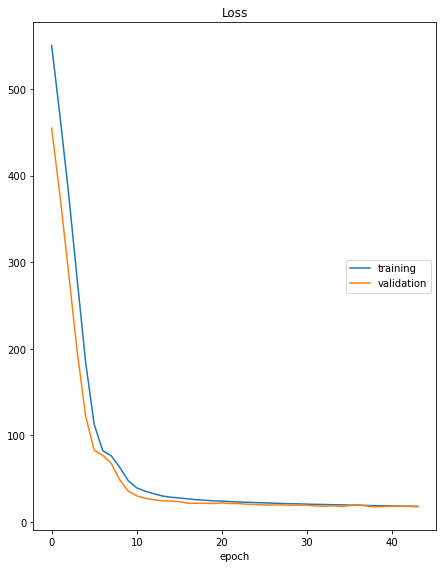

Loss
	training         	 (min:   17.954, max:  550.491, cur:   17.954)
	validation       	 (min:   17.432, max:  455.017, cur:   17.474)
5/5 [==============================] - 0s 45ms/step - loss: 17.9541 - val_loss: 17.4742
Los mejores parametros segun Grid Search: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'loss': 'mean_squared_error', 'neurons': 256, 'optimizer': 'adam', 'patience': 5}


In [16]:
from sklearn.model_selection import GridSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
# para más detalles del wrapper puede ingresar al siguiente link https://faroit.com/keras-docs/1.2.2/scikit-learn-api/
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
gs = GridSearchCV(nn_model, nn_params, cv=3)
gs.fit(X_train, Y_train)

print('Los mejores parametros segun Grid Search:', gs.best_params_)

## Método busqueda aleatoria (Randomized Search)

La busqueda aleatoria es un método de calibración de parámetros donde se consideran combinaciones aleatorias de parámetros de un conjunto determinado.

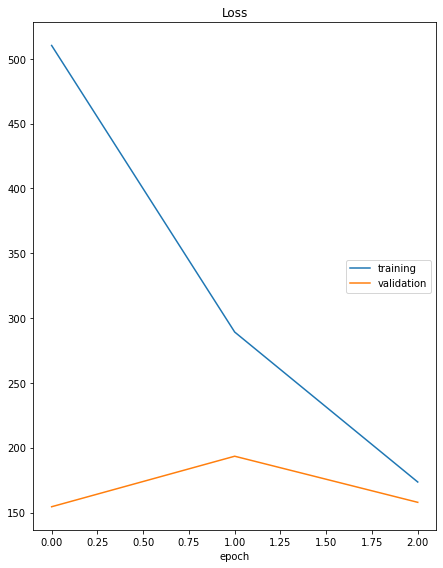

Loss
	training         	 (min:  173.525, max:  510.215, cur:  173.525)
	validation       	 (min:  154.461, max:  193.419, cur:  157.863)
3/3 [==============================] - 0s 91ms/step - loss: 173.5250 - val_loss: 157.8629
Los mejores parametros segun Randomnized Search: {'patience': 2, 'optimizer': 'sgd', 'neurons': 64, 'loss': 'mean_squared_error', 'epochs': 20, 'batch_size': 128, 'activation': 'relu'}


In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
rs = RandomizedSearchCV(nn_model, param_distributions=nn_params, n_iter=5, cv=3)
rs.fit(X_train, Y_train)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

## Comparación de resultados
En esta última sección se comparará el desempeño de la red neuronal en el set de test con la métrica del MSE, dados los parámetros calibrados que se obtuvieron en cada uno de los métodos.

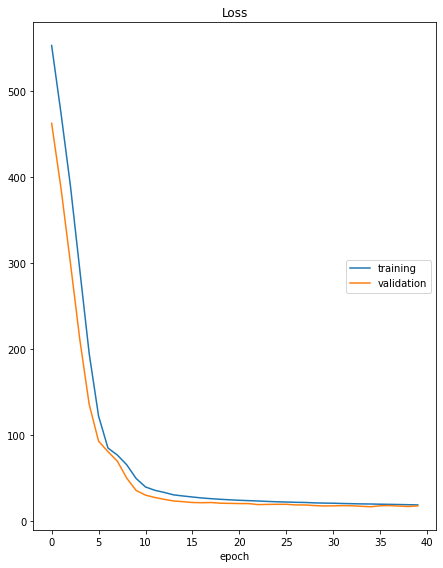

Loss
	training         	 (min:   18.595, max:  552.651, cur:   18.595)
	validation       	 (min:   16.470, max:  462.205, cur:   17.450)
5/5 [==============================] - 0s 45ms/step - loss: 18.5954 - val_loss: 17.4504
Valor de  loss  o MSE dados los parámetros de Grid Search: 18.9138240814209


In [18]:
# Desempeño de modelo con los parametros de Grid Search
model = nn_model_params(optimizer = 'adam',
                        neurons=256,
                        batch_size=64,
                        epochs=50,
                        activation='relu',
                        patience=5,
                        loss='mean_squared_error')
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Valor de ", model.metrics_names[0] ," o MSE dados los parámetros de Grid Search:", scores)

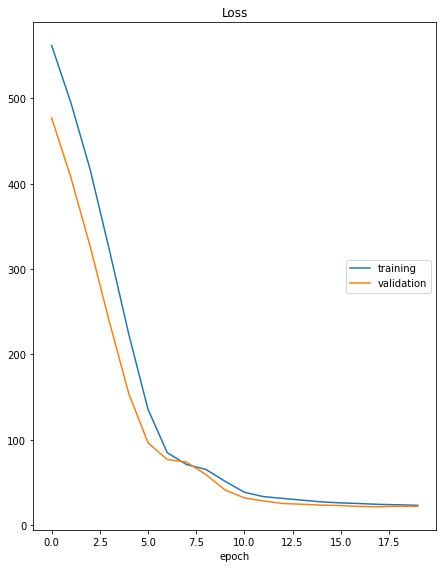

Loss
	training         	 (min:   23.300, max:  561.925, cur:   23.300)
	validation       	 (min:   21.656, max:  477.052, cur:   22.091)
5/5 [==============================] - 0s 43ms/step - loss: 23.3000 - val_loss: 22.0914
Valor de  loss  o MSE dados los parámetros de Randomized Search: 24.697595596313477


In [19]:
# Desempeño de modelo con los parametros de Randomized Search
model = nn_model_params(optimizer = 'adam',
                        neurons=256,
                        batch_size=64,
                        epochs=20,
                        activation='relu',
                        patience=5,
                        loss='mean_squared_error')
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Valor de ", model.metrics_names[0] ," o MSE dados los parámetros de Randomized Search:", scores)